In [4]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Layer
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import layers, Sequential

from keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import cv2
import os

def apply_clahe_to_dataset(input_dir, output_dir, threshold=2):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through each subdirectory in the input directory
    for subdir in os.listdir(input_dir):
        subdir_path = os.path.join(input_dir, subdir)
        if os.path.isdir(subdir_path):
            output_subdir = os.path.join(output_dir, subdir)
            if not os.path.exists(output_subdir):
                os.makedirs(output_subdir)

            # Loop through each image in the subdirectory
            for filename in os.listdir(subdir_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    # Read the image
                    img_path = os.path.join(subdir_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    # Apply CLAHE
                    clahe = cv2.createCLAHE(clipLimit=threshold)
                    clahe_img = clahe.apply(img)

                    # Save the CLAHE enhanced image
                    output_path = os.path.join(output_subdir, filename)
                    cv2.imwrite(output_path, clahe_img)

                    print(f"CLAHE applied to: {os.path.join(subdir, filename)}")

# Example usage:
input_directory = '/content/drive/MyDrive/balanced_test_dataset'
output_directory = '/content/drive/MyDrive/balanced_test_dataset-clahe'
apply_clahe_to_dataset(input_directory, output_directory, threshold=2)


CLAHE applied to: 0/14153_left.jpeg
CLAHE applied to: 0/39855_right.jpeg
CLAHE applied to: 0/15573_left.jpeg
CLAHE applied to: 0/24134_right.jpeg
CLAHE applied to: 0/19813_right.jpeg
CLAHE applied to: 0/3298_left.jpeg
CLAHE applied to: 0/25921_left.jpeg
CLAHE applied to: 0/10988_right.jpeg
CLAHE applied to: 0/36229_left.jpeg
CLAHE applied to: 0/11957_right.jpeg
CLAHE applied to: 0/32532_left.jpeg
CLAHE applied to: 0/42079_right.jpeg
CLAHE applied to: 0/1047_right.jpeg
CLAHE applied to: 0/19749_left.jpeg
CLAHE applied to: 0/15546_left.jpeg
CLAHE applied to: 0/6523_left.jpeg
CLAHE applied to: 0/1889_left.jpeg
CLAHE applied to: 0/33836_right.jpeg
CLAHE applied to: 0/37579_right.jpeg
CLAHE applied to: 0/16877_right.jpeg
CLAHE applied to: 0/37584_right.jpeg
CLAHE applied to: 0/19000_left.jpeg
CLAHE applied to: 0/17021_right.jpeg
CLAHE applied to: 0/43822_left.jpeg
CLAHE applied to: 0/40977_right.jpeg
CLAHE applied to: 0/33455_left.jpeg
CLAHE applied to: 0/4194_right.jpeg
CLAHE applied to: 0

In [ ]:
!unzip "/content/drive/MyDrive/arc.zip" -d "/content/drive/MyDrive/Messidor-2+EyePac_Balanced-Clahe"

In [ ]:
# import zipfile

# zip_file_path = '/content/drive/My Drive/archive (1).zip'  # Replace with the actual path to your zip file
# destination_folder = '/content/drive/My Drive/bDataset'  # Replace with the path to the destination folder

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_folder)


In [ ]:
# ! unzip "/content/drive/MyDrive/archive.zip" -d "/content/dataset/"

In [6]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-2,
    "N_EPOCHS": 30,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 5,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["0","1","2","3","4"],
}

In [ ]:
dataset_loc='/content/drive/MyDrive/Messidor-2+EyePac_Balanced-Clahe'

In [ ]:
datagen = ImageDataGenerator(
    #   rotation_range=10,  # Reduced from 20 to 10
    # width_shift_range=0.1,  # Reduced from 0.2 to 0.1
    # height_shift_range=0.1,  # Reduced from 0.2 to 0.1
    # shear_range=0.1,  # Reduced from 0.2 to 0.1
    # zoom_range=0.1,  # Reduced from 0.2 to 0.1
    horizontal_flip=True,
    vertical_flip=False,
    # fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
train_generator = datagen.flow_from_directory(
    dataset_loc,
    target_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    class_mode='categorical',
    subset='training'  # Specify 'training' subset for the training set
)

validation_generator = datagen.flow_from_directory(
    dataset_loc,
    target_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    class_mode='categorical',
    subset='validation'  # Specify 'validation' subset for the validation set
)

Found 1448 images belonging to 1 classes.
Found 362 images belonging to 1 classes.


In [ ]:
def display_images(generator, class_names, num_images=5):
    # Get a batch of images and labels from the generator
    X_batch, y_batch = next(generator)

    # Normalize the image data to the range [0, 1]
    X_batch = X_batch.astype('float32') / 255.0

    # Get the class labels for the batch
    y_labels = [class_names[np.argmax(label)] for label in y_batch]

    # Create a figure with a grid of subplots
    nrows = min(num_images, len(X_batch))
    ncols = 1
    figsize = (10, 5 * nrows)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    # Display the images and labels
    for i, (image, label) in enumerate(zip(X_batch[:nrows], y_labels[:nrows])):
        ax = axes[i] if nrows > 1 else axes
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display images from the training set
display_images(train_generator, CONFIGURATION["CLASS_NAMES"])


In [17]:
test_datagen = ImageDataGenerator()
    # rescale=1./255,
    # samplewise_center=True,
    # samplewise_std_normalization=True)
#
test_generator = test_datagen.flow_from_directory(
    output_directory,
    # target_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    class_mode='categorical',
    )

Found 530 images belonging to 5 classes.


In [19]:
from keras.models import load_model
model_path="/content/drive/MyDrive/resnet50.h"
model=load_model(model_path)

# Evaluate the model using the test generator
evaluation = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])


17/17 [==============================] - 134s 8s/step - loss: 3.0087 - accuracy: 0.3189 - top_k_accuracy: 0.5151
Test Loss: 3.0087382793426514
Test Accuracy: 0.31886792182922363


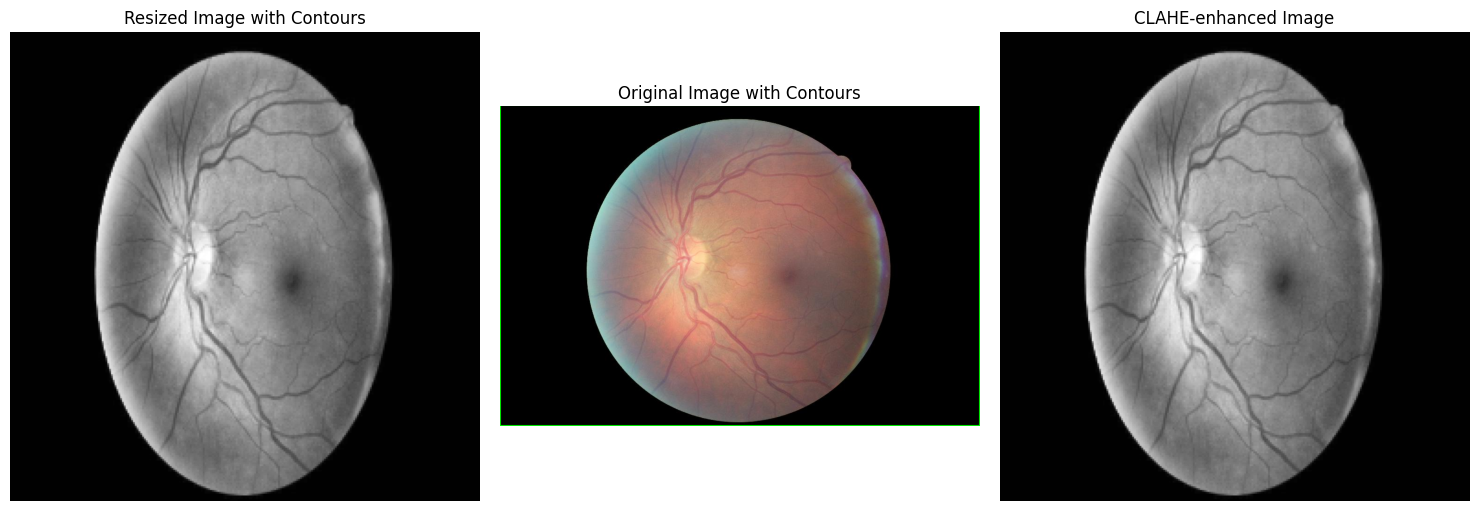

In [38]:
# import cv2
# import os
# import matplotlib.pyplot as plt
# import numpy as np

# def apply_clahe_to_image(image, threshold=2):
#     # Convert the image to grayscale
#     grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # Apply CLAHE
#     clahe = cv2.createCLAHE(clipLimit=threshold)
#     clahe_image = clahe.apply(grayscale_image)
#     return clahe_image

# def find_fundus_contour(image):
#     # Convert the image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # Apply Gaussian blur to reduce noise
#     blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#     # Apply adaptive thresholding to obtain a binary mask
#     _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     # Find contours in the binary mask
#     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     # Find the contour with a circular shape (assuming it's the fundus)
#     fundus_contour = max(contours, key=cv2.contourArea)
#     return fundus_contour

# def resize_with_roi(image, target_size):
#     # Find the contour representing the fundus area
#     fundus_contour = find_fundus_contour(image)
#     # Get contour area, perimeter, and bounding box coordinates
#     contour_area = cv2.contourArea(fundus_contour)
#     contour_perimeter = cv2.arcLength(fundus_contour, True)
#     x, y, w, h = cv2.boundingRect(fundus_contour)
#     # Calculate the center of the bounding box
#     center_x = x + w // 2
#     center_y = y + h // 2
#     # Calculate the size of the square region around the center
#     size = max(w, h)
#     half_size = size // 2
#     # Calculate the coordinates for cropping the image
#     crop_x1 = max(0, center_x - half_size)
#     crop_y1 = max(0, center_y - half_size)
#     crop_x2 = min(image.shape[1], center_x + half_size)
#     crop_y2 = min(image.shape[0], center_y + half_size)
#     # Crop the image to the square region around the center
#     cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]
#     # Resize the cropped image while maintaining the aspect ratio
#     resized_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_AREA)
#     # Apply CLAHE to the cropped image
#     resized_clahe_image = apply_clahe_to_image(resized_image, threshold=2)
#     return resized_clahe_image, image, fundus_contour, contour_area, contour_perimeter, (x, y, w, h)

# # Example usage:
# input_image_path = "/content/drive/MyDrive/balanced_test_dataset/1/11779_left.jpeg"
# # Load the original image
# original_color_image = cv2.imread(input_image_path)

# # Resize with ROI
# target_size = (256, 256)  # Target size for resizing
# resized_clahe_image, image_with_contours, fundus_contour, contour_area, contour_perimeter, bounding_box = resize_with_roi(original_color_image, target_size)

# # Draw contours on the original color image
# cv2.drawContours(image_with_contours, [fundus_contour], -1, (0, 255, 0), 2)

# # Display the resized, original with contours, and CLAHE-enhanced images
# plt.figure(figsize=(15, 5))

# # Display the resized image with contours
# plt.subplot(1, 3, 1)
# plt.imshow(resized_clahe_image, cmap='gray')
# plt.title("Resized Image with Contours")
# plt.axis('off')

# # Display the original image with contours
# plt.subplot(1, 3, 2)
# plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
# plt.title("Original Image with Contours")
# plt.axis('off')

# # Display the CLAHE-enhanced image
# plt.subplot(1, 3, 3)
# plt.imshow(resized_clahe_image, cmap='gray')
# plt.title("CLAHE-enhanced Image")
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:

# efficiencynet_model = Sequential()
# pretrained_model = tf.keras.applications.ResNet50(include_top=False,
#                                                   input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
#                                                   weights='imagenet')

# for layer in pretrained_model.layers:
#     layer.trainable = False
# efficiencynet_model.add(pretrained_model)
efficiencynet_model = Sequential()
pretrained_model = tf.keras.applications.VGG16(include_top=False,
                                                  input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
                                                  weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False
efficiencynet_model.add(pretrained_model)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
efficiencynet_model.add(Flatten())

# Add a dropout layer to prevent overfitting
efficiencynet_model.add(layers.Dropout(0.25))
# Add the output layer with softmax activation for multi-class classification
efficiencynet_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
efficiencynet_model.add(layers.Dropout(0.15))
efficiencynet_model.add(layers.Dense(5, activation='softmax',kernel_regularizer=l2(0.001)))

# Display the summary of the combined model architecture
efficiencynet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 31494981 (120.14 MB)
Trainable params: 167

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/vgg_best_weights_b',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

In [ ]:
es_callback=EarlyStopping(
    monitor='val_accuracy',min_delta=0,patience=5,verbose=1,mode='max'
    ,baseline=None,restore_best_weights=True
)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.2)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
metrics=[CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_k_accuracy")]

In [ ]:
efficiencynet_model.compile(optimizer ='adam',loss = CategoricalCrossentropy(),metrics =metrics)

In [ ]:
history=efficiencynet_model.fit(train_generator,validation_data=validation_generator,epochs=CONFIGURATION['N_EPOCHS'],verbose=1,callbacks=[checkpoint_callback ,lr_callback,es_callback])

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 3968.9578 - accuracy: 0.2251 - top_k_accuracy: 0.8667
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/drive/MyDrive/vgg_best_weights_b
46/46 [==============================] - 33s 471ms/step - loss: 3968.9578 - accuracy: 0.2251 - top_k_accuracy: 0.8667 - val_loss: 1170.6733 - val_accuracy: 0.0000e+00 - val_top_k_accuracy: 0.7403 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 14346.0225 - accuracy: 0.1775 - top_k_accuracy: 0.9689
Epoch 2: val_accuracy did not improve from 0.00000
46/46 [==============================] - 13s 270ms/step - loss: 14346.0225 - accuracy: 0.1775 - top_k_accuracy: 0.9689 - val_loss: 3694.4902 - val_accuracy: 0.0000e+00 - val_top_k_accuracy: 0.8536 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 26597.1992 - accuracy: 0.1685 - top_k_accuracy: 0.9890
Epoch 3: val_accuracy did not improve from 0.00000


KeyboardInterrupt: 

In [ ]:
val_probs = efficiencynet_model.predict(validation_generator)
ans=np.argmax(val_probs,axis=1);
print(ans)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Get the true labels and predicted labels
test_images, test_labels = [], []
for i in np.arange(validation_generator.n//validation_generator.batch_size):
    batch_images, batch_labels = validation_generator.next()
    test_images.append(batch_images)
    test_labels.append(batch_labels)


test_images = np.concatenate(test_images)
y_true = np.argmax(np.concatenate(test_labels),axis=1)

y_pred = np.argmax(efficiencynet_model.predict(test_images), axis=1)

# Get the class names
class_names = CONFIGURATION["CLASS_NAMES"]
num_classes = len(class_names)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate the class-wise accuracy
class_acc = []
for i in range(num_classes):
    true_pos = cm[i, i]
    total = np.sum(cm[:, i])
    class_acc.append(true_pos / total if total > 0 else 0)

# Print the class-wise accuracy
print("Class-wise Accuracy:")
for i, acc in enumerate(class_acc):
    print(f"{class_names[i]}: {acc * 100:.2f}%")

# Print the overall accuracy
overall_acc = np.sum(np.diag(cm)) / np.sum(cm)
print(f"\nOverall Accuracy: {overall_acc * 100:.2f}%")

In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('/content/drive/My Drive/efficiencynet.h5')

# # Evaluate the model on the test data
# efficiencynet_model = loaded_model.evaluate(test_generator, steps=test_generator.n//test_generator.batch_size)

# # print(f'Test Loss: {test_loss:.4f}')
# # print(f'Test Accuracy: {test_accuracy:.4f}')


In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# import numpy as np
# import matplotlib.pyplot as plt

# def class_wise_accuracy(y_true, y_pred):
#     cm = confusion_matrix(y_true, y_pred)
#     class_acc = cm.diagonal() / cm.sum(axis=1)
#     return class_acc

# # Evaluate the loaded model on the test generator
# # test_loss, test_accuracy = loaded_model.evaluate(test_generator, steps=test_generator.n//test_generator.batch_size)

# # print(f'Test Loss: {test_loss:.4f}')
# # print(f'Test Accuracy: {test_accuracy:.4f}')

# # Extracting predictions using the generator
# y_pred = loaded_model.predict(test_generator, steps=test_generator.n//test_generator.batch_size)

# # Storing true labels from the generator
# test_labels = []
# for i in np.arange(test_generator.n//test_generator.batch_size):
#     _, batch_labels = test_generator.next()
#     test_labels.append(batch_labels)
# # test_labels = np.concatenate(test_labels)

# # Calculate confusion matrix
# cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1))
# print("Confusion Matrix:")
# print(cm)

# # Calculate classification report
# report = classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1), zero_division=1)
# print("Classification Report:")
# print(report)

# # Calculate class-wise accuracy
# class_accuracies = class_wise_accuracy(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1))
# print("Class-wise Accuracy:")
# print(class_accuracies)

# # Visualization
# plt.figure(figsize=(8, 6))
# plt.bar(np.arange(len(class_accuracies)), class_accuracies, tick_label=np.unique(np.argmax(test_labels, axis=1)))
# plt.xlabel('Class')
# plt.ylabel('Accuracy')
# plt.title('Class-wise Accuracy')
# plt.show()


In [ ]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# efficiencynet_model.evaluate(validation_generator, steps=validation_generator.n//validation_generator.batch_size)

In [ ]:
efficiencynet_model.save('/content/drive/MyDrive/vgg.h')
# y_pred = efficiencynet_model.predict(test_images,verbose = False)

In [ ]:
# from sklearn.metrics import classification_report


# test_images, test_labels = [], []
# for i in np.arange(validation_generator.n//validation_generator.batch_size):
#     batch_images, batch_labels = test_generator.next()
#     test_images.append(batch_images)
#     test_labels.append(batch_labels)


# test_images = np.concatenate(test_images)
# test_labels = np.concatenate(test_labels)



# y_pred = efficiencynet_model.predict(test_images,verbose = False)

In [ ]:
# print(y_pred)

In [ ]:
 # y_pred_classes = np.argmax(y_pred, axis=1)
# print(y_pred_classes)
# y_true_classes = np.argmax(test_labels, axis=1)
# print(y_true_classes)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))
print(cm)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in "01234"],
                  columns = [i for i in "01234"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')

In [ ]:
# true = {
#     0: 0,
#     1: 0,
#     2: 0,
#     3: 0,
#     4: 0
# }
# total = {
#     0: 0,
#     1: 0,
#     2: 0,
#     3: 0,
#     4: 0
# }

# for i, j in zip(y_pred_classes, y_true_classes):
#     if i == j:
#         true[i] += 1
#     total[i] += 1

# for i in range(5):
#     print(true[i] , total[i])


In [ ]:
# !zip -r "/content/drive/MyDrive/arc.zip" "/content/drive/MyDrive/Messidor-2+EyePac_Balanced-Clahe"
